In [1]:
import sys
IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB:
    !pip install rdkit useful_rdkit_utils pandas mols2grid

In [2]:
import pandas as pd
import useful_rdkit_utils as uru
from rdkit import Chem
import mols2grid
from rdkit import rdBase

Input settings

<img src="https://raw.githubusercontent.com/PatWalters/practical_cheminformatics_posts/main/molmim/molmim_screenshot.png" alt="Drawing" style="width: 800px;"/>

Here's the molecule I used as input. 

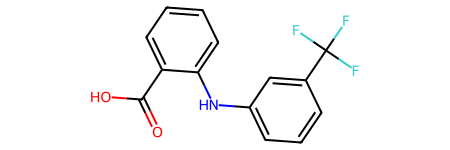

In [3]:
input_smiles = "OC(=O)c1ccccc1Nc2cccc(c2)C(F)(F)F"
Chem.MolFromSmiles(input_smiles)

Read the output from MOLMIM

In [4]:
df = pd.read_csv("https://raw.githubusercontent.com/PatWalters/practical_cheminformatics_posts/main/molmim/molmim.csv")
df.rename(columns = {"sample": "SMILES"}, inplace=True)
df.head()

,SMILES,similarity_scores
0,CN(C(=O)[C@H](O)c1ccccc1C(F)(F)F)c1ccccc1,0.943761
1,CN(C(=O)c1ccccc1C(F)(F)F)c1ccccc1C(N)=O,0.943661
2,CN(C(=O)c1ncccc1C(C)(C)C)c1ccccc1C(=O)O,0.943174
3,CN(C(=O)c1cc(C(F)(F)F)cn1C)c1ccccc1C(=O)O,0.942928
4,CN(C(=O)c1cccc(Cl)c1)c1ccccc1C(=O)O,0.942831


Check ring systems

In [5]:
ring_system_lookup = uru.RingSystemLookup.default()

In [6]:
df['ring_systems'] = df.SMILES.apply(ring_system_lookup.process_smiles)

In [7]:
df[['min_ring','min_freq']] = df.ring_systems.apply(uru.get_min_ring_frequency).to_list()

In [8]:
df.sort_values('min_freq')

,SMILES,similarity_scores,ring_systems,min_ring,min_freq
3,CN(C(=O)c1cc(C(F)(F)F)cn1C)c1ccccc1C(=O)O,0.942928,"[(c1cc[nH]c1, 29631), (c1ccccc1, 2260082)]",c1cc[nH]c1,29631
10,CN(C(=O)c1occc1Br)c1ccccc1C(=O)O,0.942018,"[(c1ccoc1, 62191), (c1ccccc1, 2260082)]",c1ccoc1,62191
49,CN(C(=O)c1cncc(C(F)(F)F)c1)c1ccccc1C(=O)O,0.941756,"[(c1ccncc1, 231698), (c1ccccc1, 2260082)]",c1ccncc1,231698
72,CN(C(=O)c1ncccc1C(F)(F)F)c1ccccc1C(=O)O,0.941756,"[(c1ccncc1, 231698), (c1ccccc1, 2260082)]",c1ccncc1,231698
71,CN(C(=O)c1ncccc1C(F)(F)F)c1ccccc1C(=O)O,0.941756,"[(c1ccncc1, 231698), (c1ccccc1, 2260082)]",c1ccncc1,231698
...,...,...,...,...,...
38,CN(C(=O)c1cccnc1C(F)(F)F)c1ccccc1C(=O)O,0.941756,"[(c1ccncc1, 231698), (c1ccccc1, 2260082)]",c1ccncc1,231698
11,O=C(O)c1ccccc1N(C(=O)C(F)(F)F)c1ccccc1,0.941951,"[(c1ccccc1, 2260082), (c1ccccc1, 2260082)]",c1ccccc1,2260082
4,CN(C(=O)c1cccc(Cl)c1)c1ccccc1C(=O)O,0.942831,"[(c1ccccc1, 2260082), (c1ccccc1, 2260082)]",c1ccccc1,2260082
1,CN(C(=O)c1ccccc1C(F)(F)F)c1ccccc1C(N)=O,0.943661,"[(c1ccccc1, 2260082), (c1ccccc1, 2260082)]",c1ccccc1,2260082


Look for duplicate molecules

In [9]:
def smi2cansmi(smi_in):
    mol = Chem.MolFromSmiles(smi_in)
    return Chem.MolToSmiles(mol)

In [10]:
df['cansmi'] = df.SMILES.apply(smi2cansmi)

In [11]:
len(df),len(df.drop_duplicates(subset="SMILES")),len(df.drop_duplicates(subset="cansmi"))

(100, 39, 39)

Cluster to find close analogs

In [12]:
blocker = rdBase.BlockLogs()
df['fp'] = df.SMILES.apply(uru.smi2morgan_fp)
del blocker

In [13]:
df['cluster'] = uru.taylor_butina_clustering(df.fp)

In [14]:
df.cluster.value_counts()

cluster
0    96
1     3
2     1
Name: count, dtype: int64

Look for molecules with objectionable functionality

In [15]:
reos = uru.REOS()
df[['reos_ruleset','reos_rule']] = df['SMILES'].apply(reos.process_smiles).to_list()
df.reos_rule.value_counts()

reos_rule
ok    100
Name: count, dtype: int64

Look at the molecules

In [16]:
mols2grid.display(df.drop_duplicates(subset="cansmi"))

MolGridWidget()